# 1. Preparations

**Basic Introduction of this notebook**

In this notebook, we perform some data maniputlation in order to map cell phones data from over 200,000 Census Block Groups (CBGs) and the daily confirmed cases of COVID-19 over 3,258 locations in the United States, to a predetermined number of clusters (in our case 1,024). The motivation of doing so is that the total number of distributed reproduction numbers grows polynomially with the number of locations (i.e., communities) we consider, and in order to reduce the computational burdens and the underfitting problem that might be caused by low amount of data when we estimating the distributed reproduction numbers, we correspondingly reduce the number of locations.

To do it, we first need to find the 1,024 clusters based on the geo-spatial locations. This is done by running a **K-Mean** algorithm on the CBGs given the number of clusters equals 1,024. We will then group cell phones data by their clusters. Each cluster will have a GPS coordinates, which is computed by the center (i.e., average coordinates) of all CBGs belong to it. Similarly, each location that reported its COVID-19 confirmed cases will be assigned to its geo-spatially closest cluster.

## 1.1 Import libraries

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import h5py
import os
import sys
import tarfile
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import matplotlib.colors as mco
import matplotlib.cm as cm

sys.path.append(os.path.abspath(
    os.path.join('__file__', '..', '..')
))

from pathlib import Path

## 1.2 File settings

To do list in this part:

1. We will check if the data, result, figure directory exist by running the **create_if_not_exist** function. If not, this function will create one.
2. We will load the cell phones data into the memory. Originally, the cell phone data is stored in a tar file. If we did not unpack the tar file yet, we will unpack it first.
3. We will load the cluster data 

In [2]:
from util.file_util import create_if_not_exist

########################
##### parameter settings
########################
extract_open_census = 0    # set to 1 if SafeGraph Open Census Data is not extracted.

###################
##### File settings
###################
# data directory
data_dir = os.path.abspath(
    os.path.join(os.path.curdir, '..', 'data')
)
create_if_not_exist(name=data_dir, type='dir')

# result directory
res_dir = os.path.abspath(
    os.path.join(os.path.curdir, '..', 'results')
)
create_if_not_exist(name=res_dir, type='dir')

# figure directory
fig_dir = os.path.abspath(
    os.path.join(os.path.curdir, '..', 'figures')
)
create_if_not_exist(name=fig_dir, type='dir')

# open result file 
resfile = os.path.join(
    res_dir, 'safegraph_analysis.hdf5'
)
create_if_not_exist(name=resfile, type='file')

complevel=7
complib='zlib'
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    print(f"File {resfile} has {len(store.keys())} entries.")

##########################################################
##### Extract SafeGraph Open Census Data if it is not yet.
##########################################################
if extract_open_census:
    # open SafeGraph Open Census Data
    open_census_file = os.path.join(
        data_dir, 'safegraph_open_census_data.tgz'
    )
    create_if_not_exist(name=open_census_file, type='file')

    with tarfile.open(open_census_file, 'r') as tar:
        tar.extractall(path=data_dir)

########################
##### read location file
########################
geofile = os.path.join(
    data_dir, 'safegraph_open_census_data', 'geometry', 'cbg.geojson'
)
create_if_not_exist(name=geofile, type='file')

geo = gpd.read_file(geofile).astype({'CensusBlockGroup': 'int64'})
geo.set_index('CensusBlockGroup', inplace=True)
geo

File /home/python/shared/results/safegraph_analysis.hdf5 has 832 entries.


StateFIPS CountyFIPS TractCode BlockGroup State  \
CensusBlockGroup                                                   
10810416001             01        081    041600          1    AL   
10810416002             01        081    041600          2    AL   
10810417004             01        081    041700          4    AL   
10730111074             01        073    011107          4    AL   
10730111084             01        073    011108          4    AL   
...                    ...        ...       ...        ...   ...   
720851902012            72        085    190201          2    PR   
720851902013            72        085    190201          3    PR   
720851902021            72        085    190202          1    PR   
720851902022            72        085    190202          2    PR   
720851903011            72        085    190301          1    PR   

                                 County ClassCode  \
CensusBlockGroup                                    
10810416001                  Lee County        H1   
10810416002                  Lee County        H1   
10810417004                  Lee County        H1   
10730111074            Jefferson County        H1   
10730111084            Jefferson County        H1   
...                                 ...       ...   
720851902012      Las Piedras Municipio        H1   
720851902013      Las Piedras Municipio        H1   
720851902021      Las Piedras Municipio        H1   
720851902022      Las Piedras Municipio        H1   
720851903011      Las Piedras Municipio        H1   

                                                           geometry  
CensusBlockGroup                                                     
10810416001       MULTIPOLYGON (((-85.37282 32.63424, -85.37275 ...  
10810416002       MULTIPOLYGON (((-85.38346 32.64838, -85.38301 ...  
10810417004       MULTIPOLYGON (((-85.37139 32.60139, -85.37138 ...  
10730111074       MULTIPOLYGON (((-86.64797 33.59205, -86.64771 ...  
10730111084       MULTIPOLYGON (((-86.65206 33.59869, -86.65204 ...  
...                                                             ...  
720851902012      MULTIPOLYGON (((-65.86850 18.18426, -65.86836 ...  
720851902013      MULTIPOLYGON (((-65.87053 18.17034, -65.87040 ...  
720851902021      MULTIPOLYGON (((-65.87678 18.17519, -65.87656 ...  
720851902022      MULTIPOLYGON (((-65.88054 18.15797, -65.87998 ...  
720851903011      MULTIPOLYGON (((-65.88778 18.15440, -65.88777 ...  

[220333 rows x 8 columns]

**For simplicity,** here we directly use the clustering results from the paper: **"A high-resolution flux-matrix model describes the spread of diseases in a spatial network and the effect of mitigation strategies."**

This paper uses the same cell phone data and confirmed cases data to model the infective rate between any two locations. Similarly, the authors clustered the locations into 1,024 clusters using K-Mean in order to reduce the computational burdens. For more information, please check the link [https://github.com/czbiohub-sf/epidemiology_flux_model/tree/main?tab=readme-ov-file]

In [3]:
key_base = Path("/clustering")

#############################
##### Load the resulting file
#############################
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:

    #####################################
    ##### Load (census block -> clusters) 
    #####################################
    key = str(key_base / "cbgs_clusters")
    data_labels = store[key]

    ########################################
    ##### Hierarchical Clustering Dendrogram
    ########################################
    # Note the leaves of Z has been ordered to minimize the distance between adjacent leaves.
    key = str(key_base / "linkage_matrix")
    Z = store[key].to_numpy()

    #####################
    ##### cluster centers
    #####################
    key = str(key_base / "clusters")
    cluster_centers = store[key].set_index('leaves').sort_index(axis=0).loc[:,['X','Y']].to_numpy()

In [4]:
cluster_centers

array([[-118.4858892 ,   34.25408588],
       [ -83.27502484,   42.70028649],
       [ -91.76188503,   35.53371852],
       ...,
       [ -80.43405378,   35.49785754],
       [ -77.14326432,   39.08790595],
       [ -90.77164039,   42.51790238]])

## Now we mark each cluster center on the map of the United States

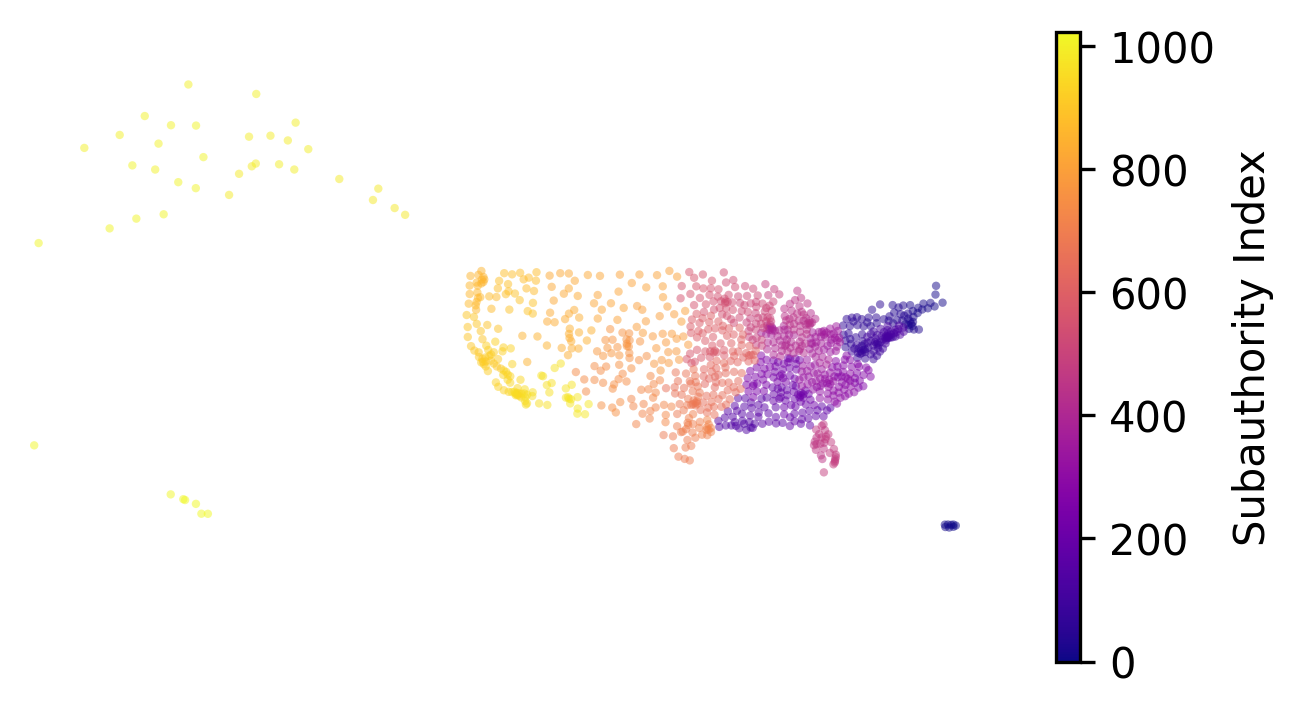

In [37]:
import matplotlib as mpl

# load ordered leaves
leaves = sch.leaves_list(Z).astype('int64')

# Get the cluster centers associated with each leaves
cluster_centers_ordered = cluster_centers[leaves]

# Get the latitude and longitude
X, Y = cluster_centers_ordered.T

npts = len(X)

# maps values within the interval [vmin, vmax] linearly to the interval [0.0, 1.0]
indices = np.arange(npts)
norm = mco.Normalize(vmin=np.min(indices), vmax=np.max(indices))
#cmap = cm.rainbow
cmap = mpl.colormaps['plasma']

# get color maps
colors = cmap(norm(indices))


fig = plt.figure(figsize=(4,3),dpi=300)
ax = fig.gca()

# Loop through all clusters
circle_size = 0.5
for i in np.arange(npts):
    x = X[i]
    y = Y[i]

    # draw a circle for each cluster
    circle = plt.Circle((x,y), circle_size, color=colors[i], alpha=0.5, lw=0)
    # put the circle on figure
    ax.add_patch(circle)

# Set boundaries
xmin = np.min(X)-circle_size
xmax = np.max(X)+circle_size
ymin = np.min(Y)-circle_size
ymax = np.max(Y)+circle_size
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect('equal')

for lab in 'left', 'right', 'bottom', 'top':
    # No axis bars
    ax.spines[lab].set_visible(False)

# No ticks
ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
cax = fig.add_axes(rect=[0.98,0.1,0.02,0.7])
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, label='Subauthority Index', extendfrac='auto')
plt.show()

In [91]:
np.min(X)

-175.82860287968717

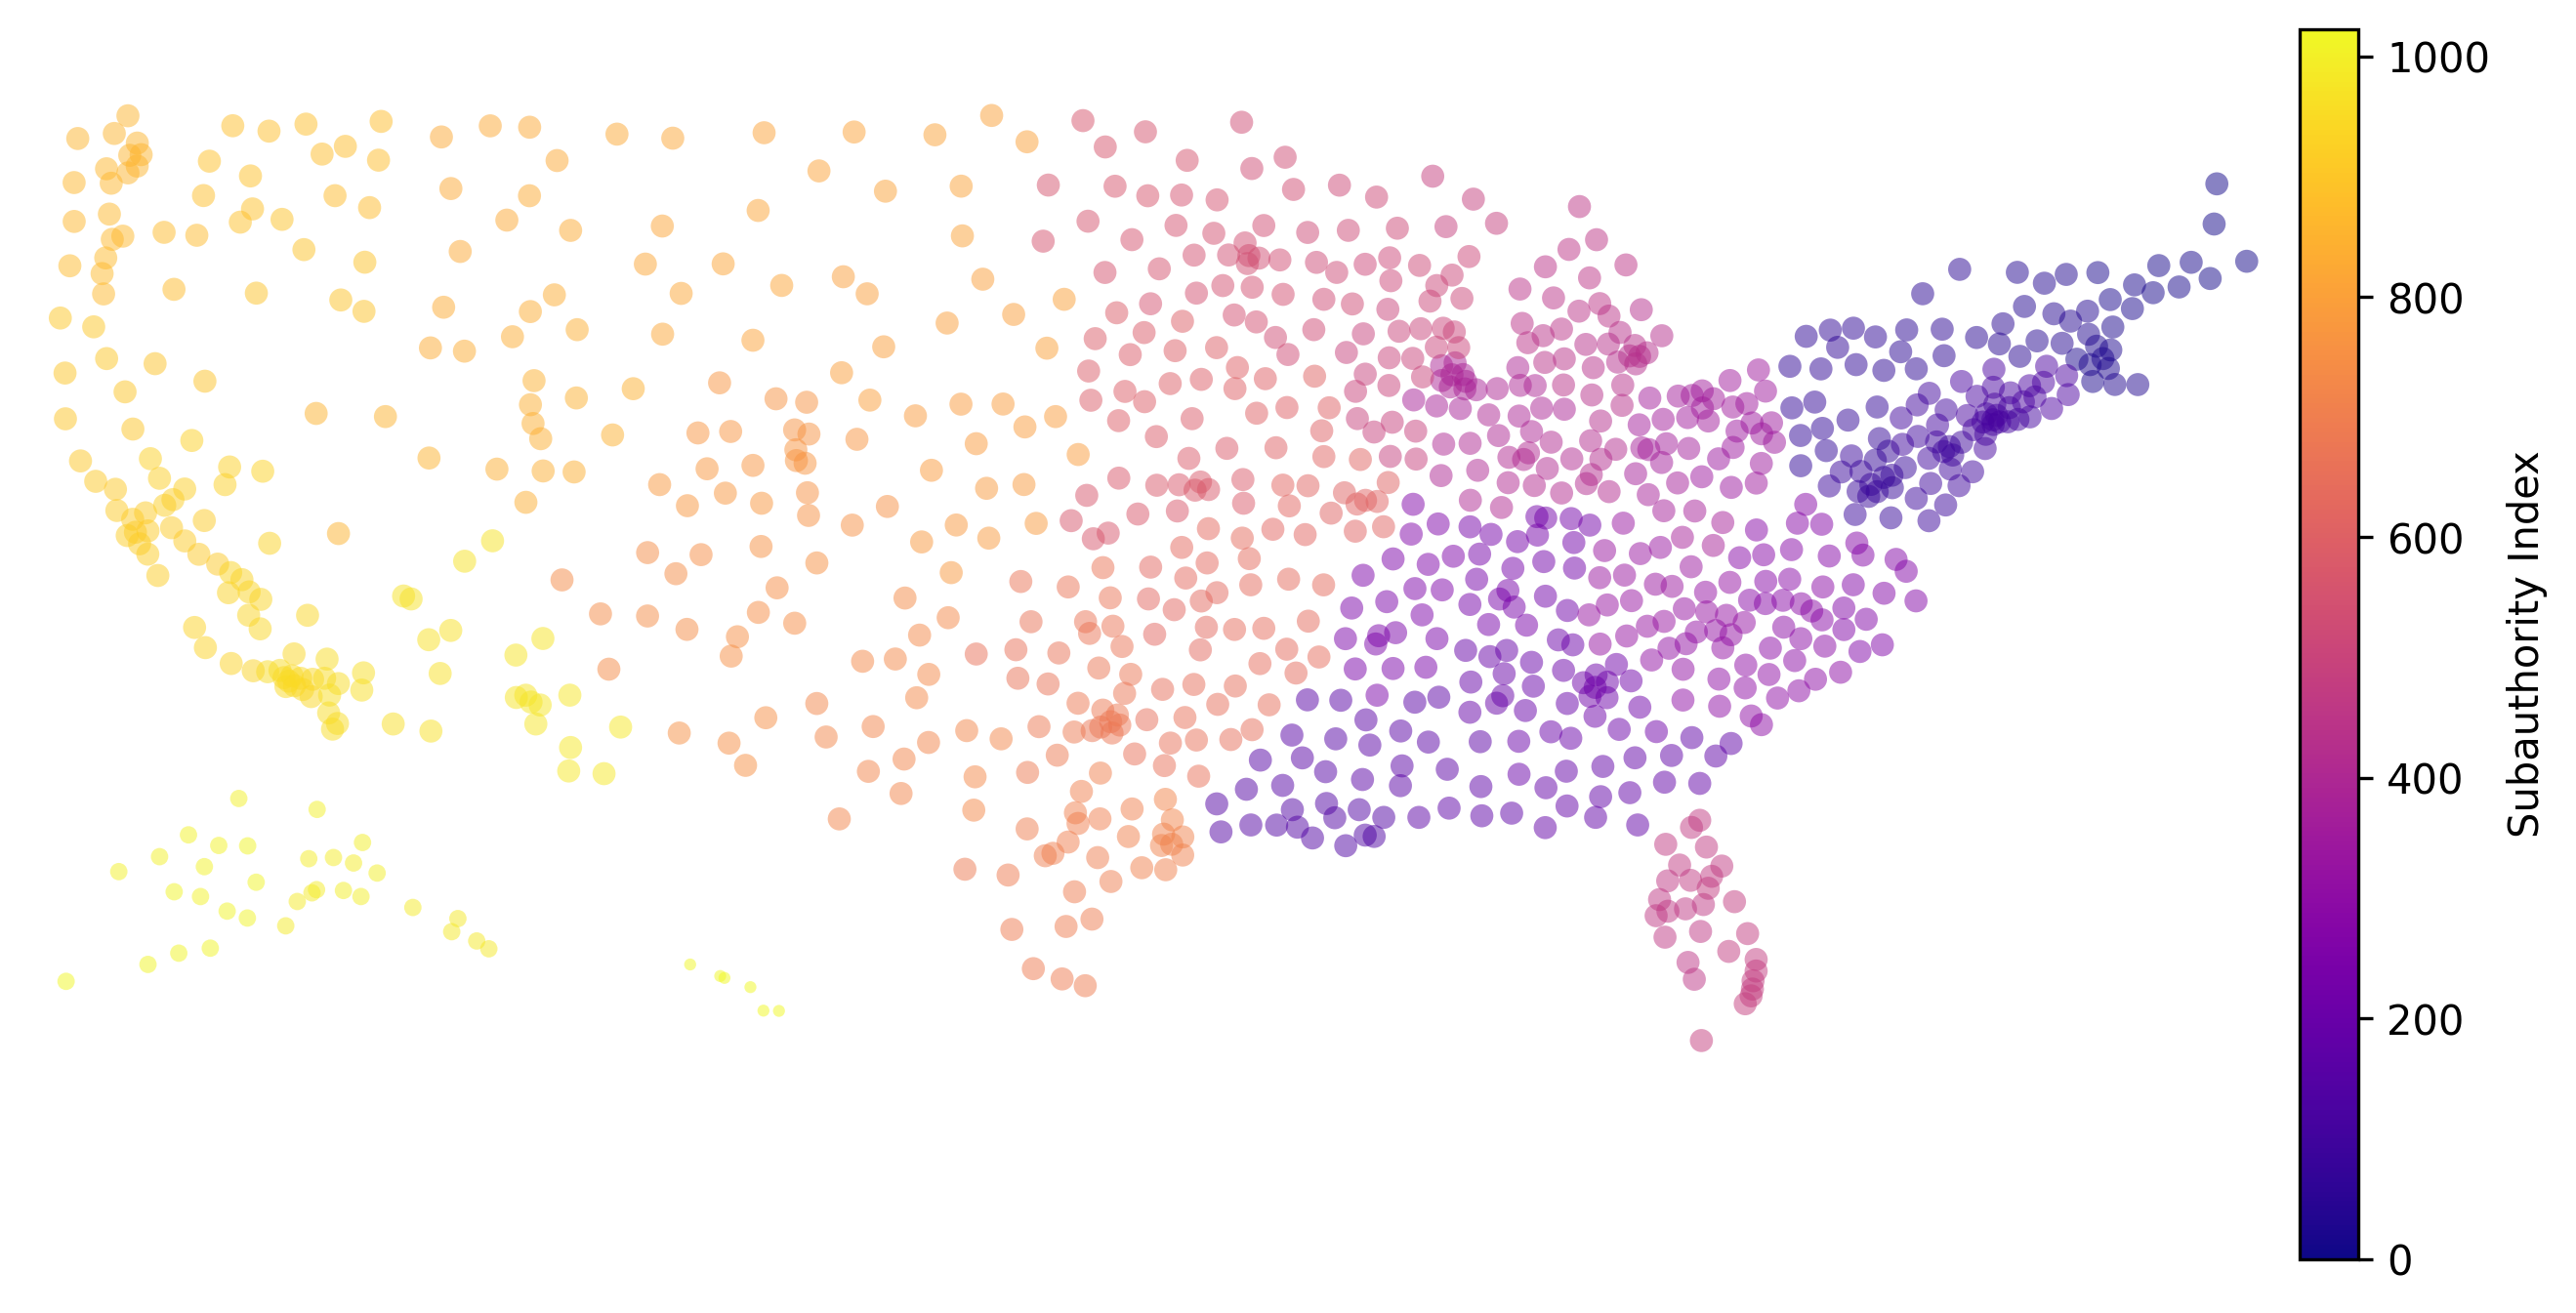

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mco
import scipy.cluster.hierarchy as sch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Assuming Z and cluster_centers are already defined
# Load ordered leaves
leaves = sch.leaves_list(Z).astype('int64')

# Get the cluster centers associated with each leaf
cluster_centers_ordered = cluster_centers[leaves]

# Get the latitude and longitude
X, Y = cluster_centers_ordered.T

npts = len(X)

# Normalize colors based on the number of points
indices = np.arange(npts)
norm = mco.Normalize(vmin=np.min(indices), vmax=np.max(indices))
cmap = plt.colormaps['plasma']

# Get color maps
colors = cmap(norm(indices))

# Create the main figure and axis for the contiguous United States
fig, ax_main = plt.subplots(figsize=(10, 6), dpi=300)

# Set boundaries for the main map
xmin, xmax = -125, -66  # Rough boundaries for the contiguous US
ymin, ymax = 24, 50

ax_main.set_xlim(xmin, xmax)
ax_main.set_ylim(ymin, ymax)
ax_main.set_aspect('equal')

# Plot circles for the contiguous United States
circle_size = 0.3
for i in np.arange(npts):
    x, y = X[i], Y[i]
    # Skip points that belong to Alaska and Hawaii (manually adjust based on coordinates)
    if x < -130 or y < 20:
        continue
    # Draw a circle for each cluster
    circle = plt.Circle((x, y), circle_size, color=colors[i], alpha=0.5, lw=0)
    ax_main.add_patch(circle)

# Add insets for Alaska and Hawaii
# Use 4-tuple for bbox_to_anchor: (x0, y0, width, height)
ax_inset_ak = inset_axes(ax_main, width="100%", height="100%", loc='lower left', bbox_to_anchor=(0, 0, 0.2, 0.3), bbox_transform=ax_main.transAxes)
ax_inset_hi = inset_axes(ax_main, width="100%", height="100%", loc='lower left', bbox_to_anchor=(0.2, 0, 0.2, 0.1), bbox_transform=ax_main.transAxes)

# Alaska plot
ax_inset_ak.set_xlim(-177, -130)
ax_inset_ak.set_ylim(50, 72)
ax_inset_ak.set_aspect('equal')

# Plot circles for Alaska
circle_size = 0.9
for i in np.arange(npts):
    x, y = X[i], Y[i]
    if -177 <= x <= -130 and 50 <= y <= 72:
        circle = plt.Circle((x, y), circle_size, color=colors[i], alpha=0.5, lw=0)
        ax_inset_ak.add_patch(circle)

# Hawaii plot
ax_inset_hi.set_xlim(-161, -154)
ax_inset_hi.set_ylim(18, 23)
ax_inset_hi.set_aspect('equal')

# Plot circles for Hawaii
circle_size = 0.3
for i in np.arange(npts):
    x, y = X[i], Y[i]
    if -161 <= x <= -154 and 18 <= y <= 23:
        circle = plt.Circle((x, y), circle_size, color=colors[i], alpha=0.5, lw=0)
        ax_inset_hi.add_patch(circle)

# Remove axis spines and ticks
for ax in [ax_main, ax_inset_ak, ax_inset_hi]:
    for lab in ['left', 'right', 'bottom', 'top']:
        ax.spines[lab].set_visible(False)
    ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

# Add color bar to the right side of the main figure
cax = fig.add_axes([0.9, 0.1, 0.02, 0.7])
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, label='Subauthority Index', extendfrac='auto')

# Show the plot
plt.show()

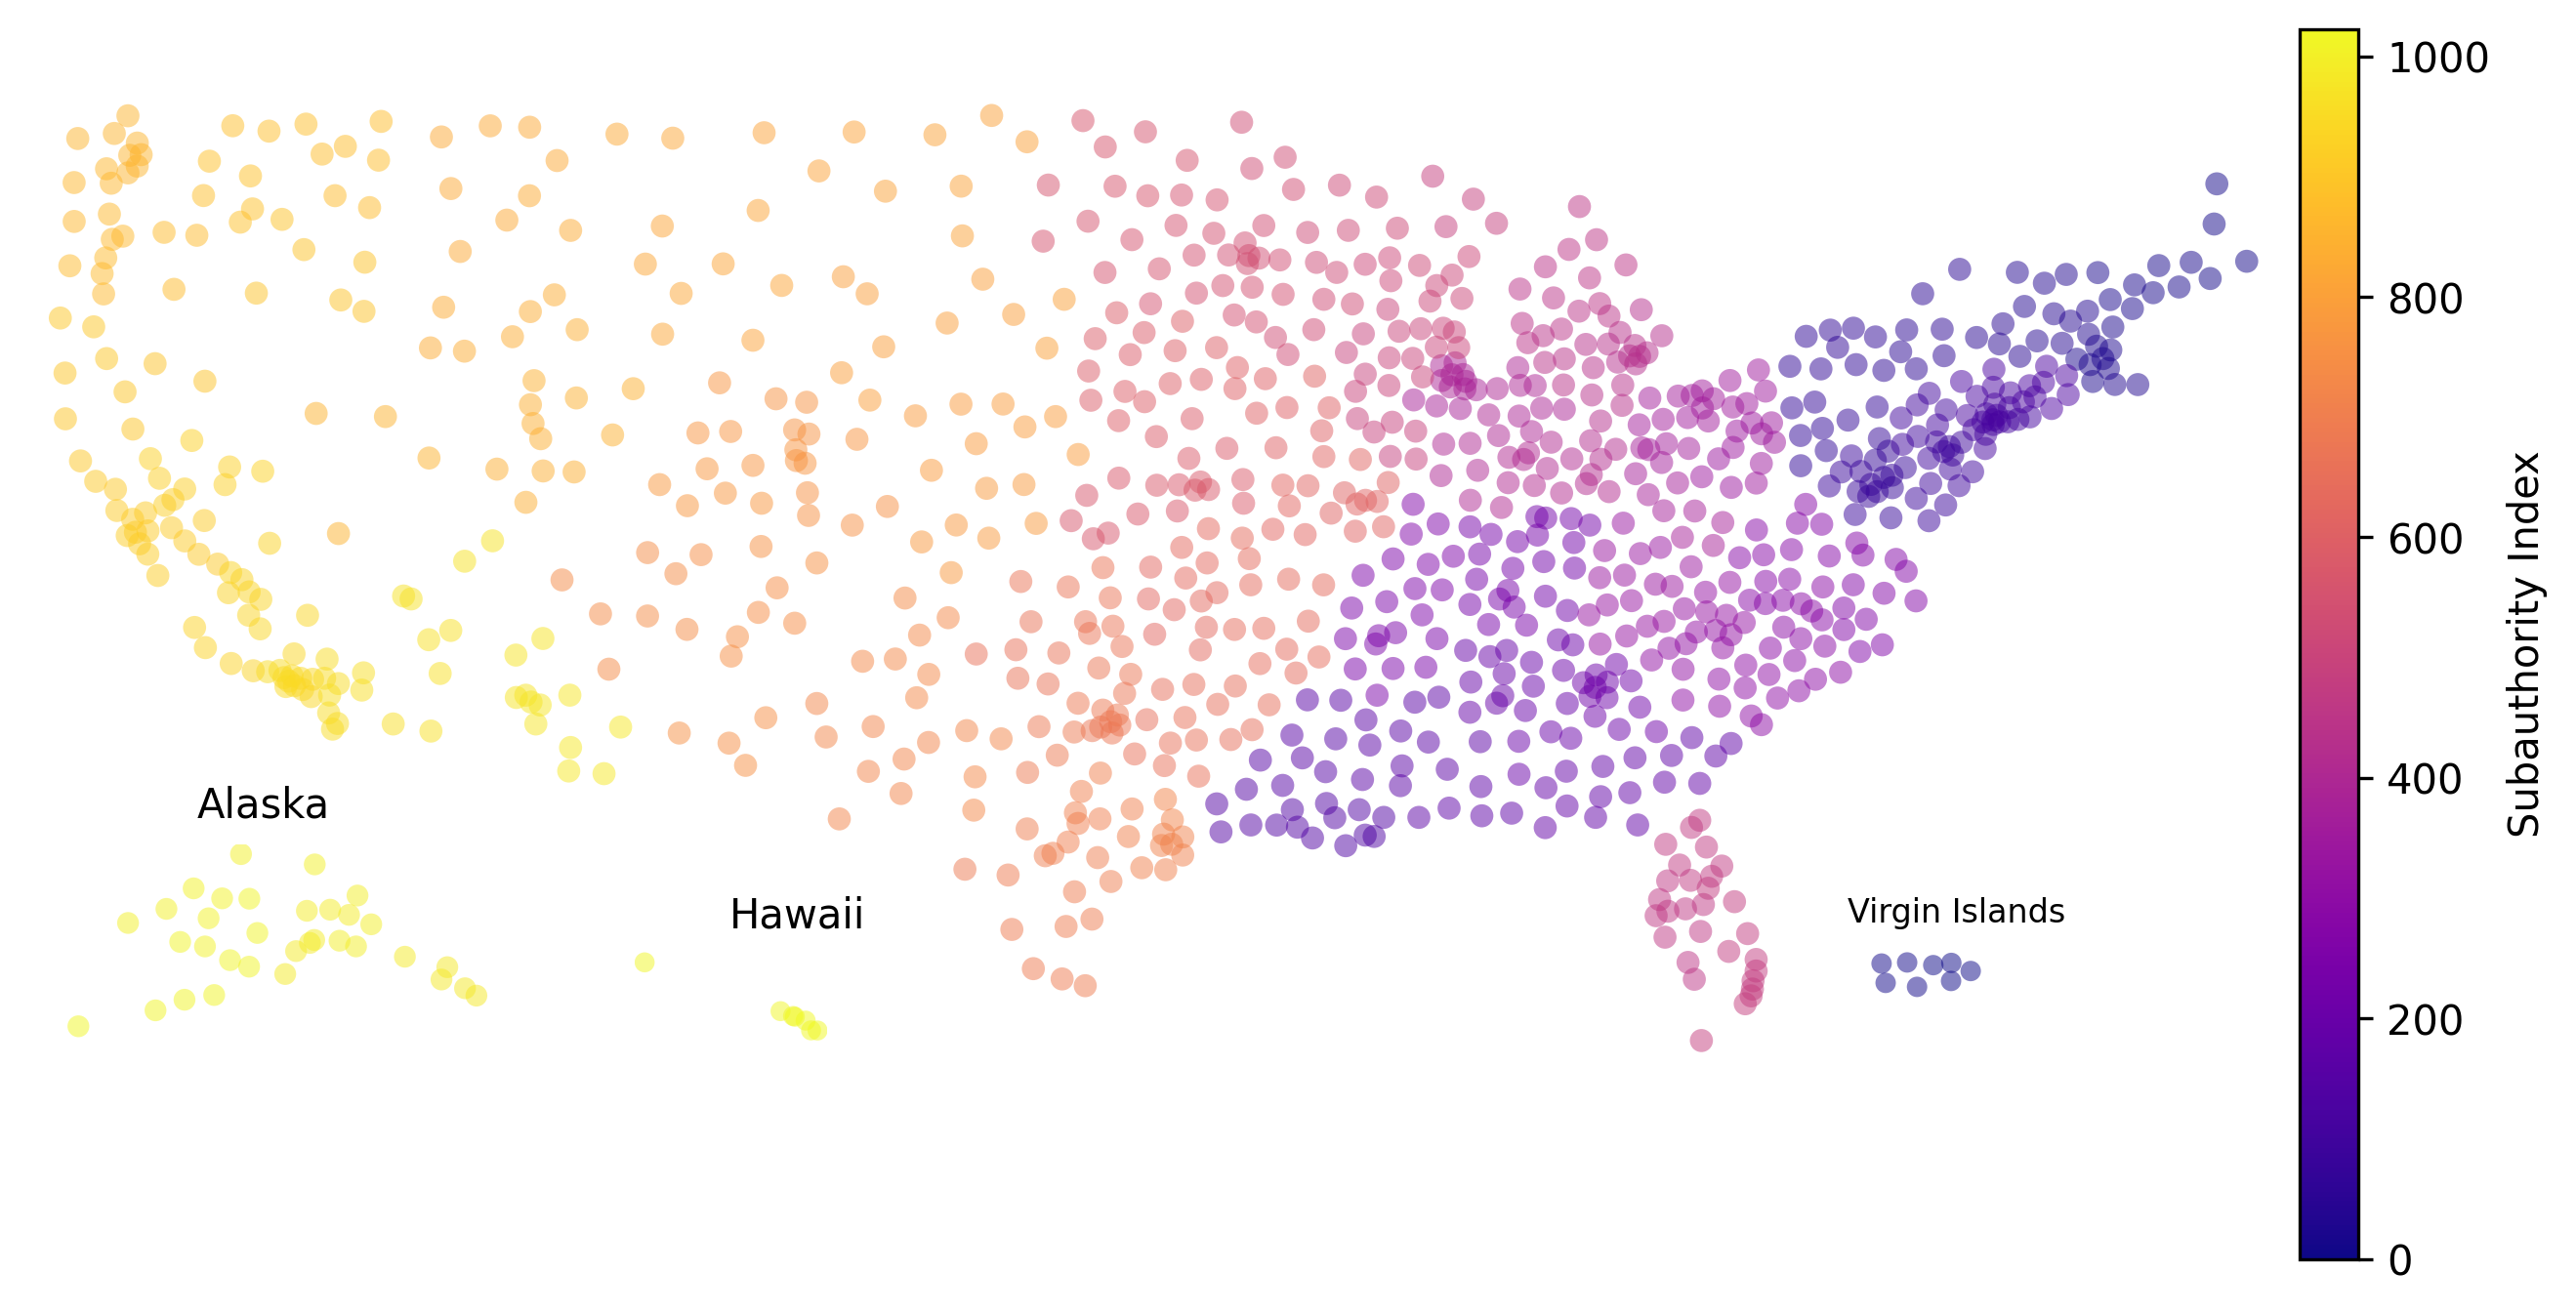

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mco
import scipy.cluster.hierarchy as sch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle

# Assuming Z and cluster_centers are already defined
# Load ordered leaves
leaves = sch.leaves_list(Z).astype('int64')

# Get the cluster centers associated with each leaf
cluster_centers_ordered = cluster_centers[leaves]

# Get the latitude and longitude
X, Y = cluster_centers_ordered.T

npts = len(X)

# Normalize colors based on the number of points
indices = np.arange(npts)
norm = mco.Normalize(vmin=np.min(indices), vmax=np.max(indices))
cmap = plt.colormaps['plasma']

# Get color maps
colors = cmap(norm(indices))

# Create the main figure and axis for the contiguous United States
fig, ax_main = plt.subplots(figsize=(10, 6), dpi=300)

# Set boundaries for the main map
xmin, xmax = -125, -66  # Rough boundaries for the contiguous US
ymin, ymax = 24, 50

ax_main.set_xlim(xmin, xmax)
ax_main.set_ylim(ymin, ymax)
ax_main.set_aspect('equal')

# Plot circles for the contiguous United States
circle_size = 0.3
for i in np.arange(npts):
    x, y = X[i], Y[i]
    # Skip points that belong to Alaska, Hawaii, or Virgin Islands (adjust based on coordinates)
    if x < -130 or (y < 20 and x > -125):
        continue
    # Draw a circle for each cluster
    circle = plt.Circle((x, y), circle_size, color=colors[i], alpha=0.5, lw=0)
    ax_main.add_patch(circle)

# Add insets for Alaska, Hawaii, and Virgin Islands
# Use 4-tuple for bbox_to_anchor: (x0, y0, width, height)
ax_inset_ak = inset_axes(ax_main, width="100%", height="100%", loc='lower left', bbox_to_anchor=(0, 0, 0.2, 0.2), bbox_transform=ax_main.transAxes)


ax_inset_hi = inset_axes(ax_main, width="100%", height="100%", loc='lower left', bbox_to_anchor=(0.2, 0, 0.2, 0.1), bbox_transform=ax_main.transAxes)
ax_inset_vi = inset_axes(ax_main, width="100%", height="100%", loc='lower left', bbox_to_anchor=(0.78, 0, 0.15, 0.15), bbox_transform=ax_main.transAxes)

# Alaska plot
ax_inset_ak.set_xlim(-177, -130)
ax_inset_ak.set_ylim(50, 72)
ax_inset_ak.set_aspect('equal')

# Plot circles for Alaska
circle_size = 1.2
for i in np.arange(npts):
    x, y = X[i], Y[i]
    if -177 <= x <= -130 and 50 <= y <= 72:
        circle = plt.Circle((x, y), circle_size, color=colors[i], alpha=0.5, lw=0)
        ax_inset_ak.add_patch(circle)

ax_inset_ak.text(-155, 75, 'Alaska', fontsize=10, ha='center')

# Hawaii plot
ax_inset_hi.set_xlim(-177, -154)
ax_inset_hi.set_ylim(18, 30)
ax_inset_hi.set_aspect('equal')

# Plot circles for Hawaii
circle_size = 1.2
for i in np.arange(npts):
    x, y = X[i], Y[i]
    if -177 <= x <= -154 and 18 <= y <= 30:
        circle = plt.Circle((x, y), circle_size, color=colors[i], alpha=0.5, lw=0)
        ax_inset_hi.add_patch(circle)

# Add label for Hawaii
ax_inset_hi.text(-157.5, 32, 'Hawaii', fontsize=10, ha='center')

# Virgin Islands plot
ax_inset_vi.set_xlim(-68, -63)  # More zoomed-in x-limits for Virgin Islands
ax_inset_vi.set_ylim(17.6, 19)   # More zoomed-in y-limits for Virgin Islands
ax_inset_vi.set_aspect('equal')

# Plot circles for Virgin Islands
circle_size = 0.15
for i in np.arange(npts):
    x, y = X[i], Y[i]
    if -68 <= x <= -63 and 17.6 <= y <= 19:
        circle = plt.Circle((x, y), circle_size, color=colors[i], alpha=0.5, lw=0)
        ax_inset_vi.add_patch(circle)

# Add label for Virgin Islands
ax_inset_vi.text(-66, 19, 'Virgin Islands', fontsize=8, ha='center')

# Remove axis spines and ticks
for ax in [ax_main, ax_inset_ak, ax_inset_hi, ax_inset_vi]:
    for lab in ['left', 'right', 'bottom', 'top']:
        ax.spines[lab].set_visible(False)
    ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

# Add color bar to the right side of the main figure
cax = fig.add_axes([0.9, 0.1, 0.02, 0.7])
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, label='Subauthority Index', extendfrac='auto')

# Show the plot
plt.show()

In [103]:
# Save this pic
fname = 'clusters_after_first_clustering'
exts = ['.png', '.svg']
dpi=300

for ext in exts:
    filepath = os.path.join(fig_dir, fname+ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

Written file: /home/python/shared/figures/clusters_after_first_clustering.png
Written file: /home/python/shared/figures/clusters_after_first_clustering.svg


## Now we can fill up clusters with more information

In [6]:
groups = data_labels.groupby(['leaves']).groups
groups = [groups[i].tolist() for i in range(len(cluster_centers))]

# Group with ordered leaves
groups_ordered = [groups[leaves[i]] for i in range(len(leaves))]

### Concate the dataframe with location, id of subcommunities, and leaves id

In [7]:
df = pd.DataFrame(data=cluster_centers_ordered, columns=['X', 'Y'])
df = pd.concat([df, pd.DataFrame(pd.Series(groups_ordered), columns=['cbg_clusters'])], axis=1)
df = pd.concat([df, pd.DataFrame(pd.Series(leaves), columns=['leaves'])], axis=1)
df

X          Y  \
0     -65.794825  18.277415   
1     -66.083320  18.131576   
2     -66.079340  18.396328   
3     -66.344566  18.363775   
4     -66.582628  18.044742   
...          ...        ...   
1019 -158.026269  21.423245   
1020 -157.813184  21.329035   
1021 -156.517054  20.867763   
1022 -155.865732  19.692965   
1023 -155.089968  19.680449   

                                           cbg_clusters  leaves  
0     [720531504003, 720531501044, 720531505001, 720...     746  
1     [720572702011, 720572703004, 720572705001, 720...     458  
2     [720210307001, 720210310113, 720210316223, 720...     873  
3     [720399559001, 720399556001, 720399557001, 720...       8  
4     [721130724005, 721130727011, 721130727012, 721...     641  
...                                                 ...     ...  
1019  [150030078092, 150030078102, 150030099044, 150...     911  
1020  [150090318011, 150099900000, 150030047001, 150...       7  
1021  [150090311032, 150090304042, 150090309034, 150...     392  
1022  [150010216012, 150010214023, 150010216041, 150...     808  
1023  [150010210053, 150010210052, 150019904000, 150...     134  

[1024 rows x 4 columns]

### Fill in total population

In [8]:
columns = ['B01001e1']

# Load population from US Census
file_name = os.path.join(
    data_dir, 'safegraph_open_census_data', 'data', 'cbg_b01.csv'
)
cbg_data = pd.read_csv(file_name).set_index('census_block_group').loc[:,columns]
cbg_data

B01001e1
census_block_group          
10010201001              745
10010201002             1265
10010202001              960
10010202002             1236
10010203001             2364
...                      ...
721537506011             921
721537506012            2703
721537506013            1195
721537506021            2005
721537506022             736

[220333 rows x 1 columns]

In [9]:
data_labels['population']= cbg_data.loc[data_labels.index]
data_labels

leaves  population
CensusBlockGroup                    
10810416001           68        2434
10810416002           68        1136
10810417004           68        2589
10730111074          440        3952
10730111084          440         764
...                  ...         ...
720851902012         746         447
720851902013         746        2281
720851902021         746        1229
720851902022         746        2580
720851903011         746        2621

[220333 rows x 2 columns]

In [10]:
# Group by leaves, get the sum of population
pop = data_labels.groupby(by='leaves')['population'].sum().to_frame()
pop

population
leaves            
0          1592498
1           582883
2           174688
3           195108
4           399160
...            ...
1019        123493
1020         68224
1021        356071
1022        886679
1023        157401

[1024 rows x 1 columns]

In [11]:
# Join df with pop
df.reset_index(inplace=True)
df.set_index('leaves', inplace=True)
df.loc[pop.index,'population'] = pop['population']
df.reset_index(inplace=True)
df.set_index('index', inplace=True)
df

leaves           X          Y  \
index                                  
0         746  -65.794825  18.277415   
1         458  -66.083320  18.131576   
2         873  -66.079340  18.396328   
3           8  -66.344566  18.363775   
4         641  -66.582628  18.044742   
...       ...         ...        ...   
1019      911 -158.026269  21.423245   
1020        7 -157.813184  21.329035   
1021      392 -156.517054  20.867763   
1022      808 -155.865732  19.692965   
1023      134 -155.089968  19.680449   

                                            cbg_clusters  population  
index                                                                 
0      [720531504003, 720531501044, 720531505001, 720...    390728.0  
1      [720572702011, 720572703004, 720572705001, 720...    488287.0  
2      [720210307001, 720210310113, 720210316223, 720...   1011530.0  
3      [720399559001, 720399556001, 720399557001, 720...    425126.0  
4      [721130724005, 721130727011, 721130727012, 721...    354598.0  
...                                                  ...         ...  
1019   [150030078092, 150030078102, 150030099044, 150...    459209.0  
1020   [150090318011, 150099900000, 150030047001, 150...    529047.0  
1021   [150090311032, 150090304042, 150090309034, 150...    161290.0  
1022   [150010216012, 150010214023, 150010216041, 150...     88670.0  
1023   [150010210053, 150010210052, 150019904000, 150...    105010.0  

[1024 rows x 5 columns]

In [12]:
# senity check: is there any empty community once the CBGs are clustered using SafeGraph data.
df.loc[df['population'] == 0]


leaves           X          Y    cbg_clusters  population
index                                                           
1017      236 -175.828603  27.854941  [150039812001]         0.0

So there is one

## Importing CSSEGI data into communities

We first get the location data of each cluster.

In [13]:
clusters_pos = df.loc[:, ['X', 'Y']].rename(columns={'X': 'longitude', 'Y': 'latitude'})
clusters_pos

longitude   latitude
index                       
0      -65.794825  18.277415
1      -66.083320  18.131576
2      -66.079340  18.396328
3      -66.344566  18.363775
4      -66.582628  18.044742
...           ...        ...
1019  -158.026269  21.423245
1020  -157.813184  21.329035
1021  -156.517054  20.867763
1022  -155.865732  19.692965
1023  -155.089968  19.680449

[1024 rows x 2 columns]

Next, let's load the geometry data from each subcommunity.

In [14]:
# For each community, we use a "representive point" that is guaranteed to be within the boundary to represent the center community
XY = geo.representative_point().apply(lambda X: [X.x, X.y]).tolist()
df_xy = pd.DataFrame(data=np.array(XY), index=geo.index, columns=['longitude', 'latitude'])
df_xy

longitude   latitude
CensusBlockGroup                      
10810416001      -85.359042  32.649834
10810416002      -85.375454  32.649834
10810417004      -85.352368  32.585058
10730111074      -86.623536  33.598117
10730111084      -86.629025  33.605849
...                     ...        ...
720851902012     -65.865443  18.186016
720851902013     -65.863139  18.172725
720851902021     -65.868816  18.176952
720851902022     -65.874959  18.165179
720851903011     -65.873640  18.154453

[220333 rows x 2 columns]

Now we load the confirmed cases from CSSEGI data.

In [15]:
dfile = os.path.join(data_dir, 'time_series_covid19_confirmed_US.csv')
df_confirmed_us = pd.read_csv(dfile)
df_confirmed_us = df_confirmed_us.loc[df_confirmed_us['iso2'] == 'US'] # only keep the US
df_confirmed_us

UID iso2 iso3  code3     FIPS      Admin2 Province_State  \
0     84001001   US  USA    840   1001.0     Autauga        Alabama   
1     84001003   US  USA    840   1003.0     Baldwin        Alabama   
2     84001005   US  USA    840   1005.0     Barbour        Alabama   
3     84001007   US  USA    840   1007.0        Bibb        Alabama   
4     84001009   US  USA    840   1009.0      Blount        Alabama   
...        ...  ...  ...    ...      ...         ...            ...   
3337  84056039   US  USA    840  56039.0       Teton        Wyoming   
3338  84056041   US  USA    840  56041.0       Uinta        Wyoming   
3339  84090056   US  USA    840  90056.0  Unassigned        Wyoming   
3340  84056043   US  USA    840  56043.0    Washakie        Wyoming   
3341  84056045   US  USA    840  56045.0      Weston        Wyoming   

     Country_Region        Lat       Long_  ... 4/11/21  4/12/21  4/13/21  \
0                US  32.539527  -86.644082  ...    6723     6727     6734   
1                US  30.727750  -87.722071  ...   20631    20638    20652   
2                US  31.868263  -85.387129  ...    2247     2249     2252   
3                US  32.996421  -87.125115  ...    2562     2564     2564   
4                US  33.982109  -86.567906  ...    6483     6488     6497   
...             ...        ...         ...  ...     ...      ...      ...   
3337             US  43.935225 -110.589080  ...    3660     3665     3675   
3338             US  41.287818 -110.547578  ...    2142     2145     2153   
3339             US   0.000000    0.000000  ...       0        0        0   
3340             US  43.904516 -107.680187  ...     897      897      898   
3341             US  43.839612 -104.567488  ...     640      641      642   

      4/14/21  4/15/21  4/16/21  4/17/21  4/18/21  4/19/21  4/20/21  
0        6740     6748     6750     6760     6763     6763     6773  
1       20670    20674    20701    20714    20723    20730    20764  
2        2257     2262     2264     2271     2271     2271     2275  
3        2559     2560     2560     2563     2563     2567     2569  
4        6507     6511     6519     6529     6532     6532     6548  
...       ...      ...      ...      ...      ...      ...      ...  
3337     3684     3689     3694     3694     3694     3703     3707  
3338     2153     2155     2155     2155     2155     2150     2155  
3339        0        0        0        0        0        0        0  
3340      898      898      898      898      898      898      898  
3341      646      646      646      646      646      647      647  

[3258 rows x 466 columns]

Drop the locations with no latitude or longitude information

In [16]:
idx = ( (df_confirmed_us['Lat'] == 0.) | (df_confirmed_us['Long_'] == 0.) )
df_confirmed_us.drop(index=df_confirmed_us.index[idx], inplace=True)
df_confirmed_us

UID iso2 iso3  code3     FIPS      Admin2 Province_State  \
0     84001001   US  USA    840   1001.0     Autauga        Alabama   
1     84001003   US  USA    840   1003.0     Baldwin        Alabama   
2     84001005   US  USA    840   1005.0     Barbour        Alabama   
3     84001007   US  USA    840   1007.0        Bibb        Alabama   
4     84001009   US  USA    840   1009.0      Blount        Alabama   
...        ...  ...  ...    ...      ...         ...            ...   
3336  84056037   US  USA    840  56037.0  Sweetwater        Wyoming   
3337  84056039   US  USA    840  56039.0       Teton        Wyoming   
3338  84056041   US  USA    840  56041.0       Uinta        Wyoming   
3340  84056043   US  USA    840  56043.0    Washakie        Wyoming   
3341  84056045   US  USA    840  56045.0      Weston        Wyoming   

     Country_Region        Lat       Long_  ... 4/11/21  4/12/21  4/13/21  \
0                US  32.539527  -86.644082  ...    6723     6727     6734   
1                US  30.727750  -87.722071  ...   20631    20638    20652   
2                US  31.868263  -85.387129  ...    2247     2249     2252   
3                US  32.996421  -87.125115  ...    2562     2564     2564   
4                US  33.982109  -86.567906  ...    6483     6488     6497   
...             ...        ...         ...  ...     ...      ...      ...   
3336             US  41.659439 -108.882788  ...    4085     4104     4107   
3337             US  43.935225 -110.589080  ...    3660     3665     3675   
3338             US  41.287818 -110.547578  ...    2142     2145     2153   
3340             US  43.904516 -107.680187  ...     897      897      898   
3341             US  43.839612 -104.567488  ...     640      641      642   

      4/14/21  4/15/21  4/16/21  4/17/21  4/18/21  4/19/21  4/20/21  
0        6740     6748     6750     6760     6763     6763     6773  
1       20670    20674    20701    20714    20723    20730    20764  
2        2257     2262     2264     2271     2271     2271     2275  
3        2559     2560     2560     2563     2563     2567     2569  
4        6507     6511     6519     6529     6532     6532     6548  
...       ...      ...      ...      ...      ...      ...      ...  
3336     4115     4119     4119     4119     4119     4126     4135  
3337     3684     3689     3694     3694     3694     3703     3707  
3338     2153     2155     2155     2155     2155     2150     2155  
3340      898      898      898      898      898      898      898  
3341      646      646      646      646      646      647      647  

[3152 rows x 466 columns]

### Mapping clusters to CSSEGI FIPS based on (Longitude, Latitude)

In [17]:
# clusters_pos should already be sorted, but sort it to make sure
clusters_pos.sort_index(inplace=True)

# get the clusters geometry location in numpy array
XY_clusters = clusters_pos.loc[:, ['longitude', 'latitude']].to_numpy()

# get the CSSEGI geometry location in numpy array
XY_csse = df_confirmed_us.loc[:, ['Long_', 'Lat']].to_numpy()

# iterate over CSSEGI data
cluster_ids = []
for i in range(len(df_confirmed_us.index)):
    # For each CSSEGI region, find the closest cluster
    xy = XY_csse[i]
    imin = np.argmin(np.linalg.norm(XY_clusters - xy, axis=1))
    cluster_ids.append(clusters_pos.index[imin])

# Join corresponding cluster id with CSSEGI 
col = 'cluster_id'
if col in df_confirmed_us.columns:
    del df_confirmed_us[col]

df_confirmed_us.insert(1, col, cluster_ids)
df_confirmed_us

UID  cluster_id iso2 iso3  code3     FIPS      Admin2  \
0     84001001         202   US  USA    840   1001.0     Autauga   
1     84001003         168   US  USA    840   1003.0     Baldwin   
2     84001005         184   US  USA    840   1005.0     Barbour   
3     84001007         188   US  USA    840   1007.0        Bibb   
4     84001009         193   US  USA    840   1009.0      Blount   
...        ...         ...  ...  ...    ...      ...         ...   
3336  84056037         847   US  USA    840  56037.0  Sweetwater   
3337  84056039         835   US  USA    840  56039.0       Teton   
3338  84056041         845   US  USA    840  56041.0       Uinta   
3340  84056043         817   US  USA    840  56043.0    Washakie   
3341  84056045         792   US  USA    840  56045.0      Weston   

     Province_State Country_Region        Lat  ...  4/11/21 4/12/21  4/13/21  \
0           Alabama             US  32.539527  ...     6723    6727     6734   
1           Alabama             US  30.727750  ...    20631   20638    20652   
2           Alabama             US  31.868263  ...     2247    2249     2252   
3           Alabama             US  32.996421  ...     2562    2564     2564   
4           Alabama             US  33.982109  ...     6483    6488     6497   
...             ...            ...        ...  ...      ...     ...      ...   
3336        Wyoming             US  41.659439  ...     4085    4104     4107   
3337        Wyoming             US  43.935225  ...     3660    3665     3675   
3338        Wyoming             US  41.287818  ...     2142    2145     2153   
3340        Wyoming             US  43.904516  ...      897     897      898   
3341        Wyoming             US  43.839612  ...      640     641      642   

      4/14/21  4/15/21  4/16/21  4/17/21  4/18/21  4/19/21  4/20/21  
0        6740     6748     6750     6760     6763     6763     6773  
1       20670    20674    20701    20714    20723    20730    20764  
2        2257     2262     2264     2271     2271     2271     2275  
3        2559     2560     2560     2563     2563     2567     2569  
4        6507     6511     6519     6529     6532     6532     6548  
...       ...      ...      ...      ...      ...      ...      ...  
3336     4115     4119     4119     4119     4119     4126     4135  
3337     3684     3689     3694     3694     3694     3703     3707  
3338     2153     2155     2155     2155     2155     2150     2155  
3340      898      898      898      898      898      898      898  
3341      646      646      646      646      646      647      647  

[3152 rows x 467 columns]

### Retain only the dates and cluster_ID


In [18]:
import datetime
dates = []
for c in df_confirmed_us.columns:
    try:
        t = datetime.datetime.strptime(c, '%m/%d/%y')
        dates.append(c)
    except ValueError:
        continue

In [19]:
# We only need the cluster_id and dates
columns = ['cluster_id'] + dates

df_clusters = df_confirmed_us.loc[:, columns].groupby('cluster_id').apply(sum)
del df_clusters['cluster_id']
df_clusters

1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  1/28/20  \
cluster_id                                                                  
8                 0        0        0        0        0        0        0   
9                 0        0        0        0        0        0        0   
10                0        0        0        0        0        0        0   
11                0        0        0        0        0        0        0   
12                0        0        0        0        0        0        0   
...             ...      ...      ...      ...      ...      ...      ...   
1016              0        0        0        0        0        0        0   
1018              0        0        0        0        0        0        0   
1019              0        0        0        0        0        0        0   
1021              0        0        0        0        0        0        0   
1022              0        0        0        0        0        0        0   

            1/29/20  1/30/20  1/31/20  ...  4/11/21  4/12/21  4/13/21  \
cluster_id                             ...                              
8                 0        0        0  ...     1473     1496     1511   
9                 0        0        0  ...      398      398      401   
10                0        0        0  ...      795      795      797   
11                0        0        0  ...     1131     1149     1161   
12                0        0        0  ...     4859     4886     4921   
...             ...      ...      ...  ...      ...      ...      ...   
1016              0        0        0  ...      657      658      679   
1018              0        0        0  ...      202      202      202   
1019              0        0        0  ...    24243    24291    24330   
1021              0        0        0  ...     3971     3986     4004   
1022              0        0        0  ...     2629     2634     2639   

            4/14/21  4/15/21  4/16/21  4/17/21  4/18/21  4/19/21  4/20/21  
cluster_id                                                                 
8              1522     1531     1544     1556     1560     1561     1567  
9               405      407      412      416      420      423      424  
10              799      805      807      807      808      809      816  
11             1169     1177     1185     1193     1194     1201     1202  
12             4955     4998     5015     5048     5068     5076     5116  
...             ...      ...      ...      ...      ...      ...      ...  
1016            679      679      681      681      681      683      686  
1018            202      202      202      203      203      203      203  
1019          24365    24422    24537    24585    24678    24730    24754  
1021           4021     4045     4100     4136     4142     4152     4165  
1022           2654     2668     2671     2682     2692     2694     2695  

[955 rows x 455 columns]

Now we combine the data together. We want: for each date, the total cumulative infected number for each cluster

In [20]:
clusters_csse = pd.DataFrame(data=np.zeros((len(df.index),len(df_clusters.columns)), np.uint), index=df.index, columns=df_clusters.columns)
clusters_csse.loc[df_clusters.index] = df_clusters
clusters_csse = clusters_csse.T
clusters_csse.index = [datetime.datetime.strptime(s, '%m/%d/%y') for s in clusters_csse.index]
clusters_csse

index       0     1     2     3     4     5     6     7     8     9     ...  \
2020-01-22     0     0     0     0     0     0     0     0     0     0  ...   
2020-01-23     0     0     0     0     0     0     0     0     0     0  ...   
2020-01-24     0     0     0     0     0     0     0     0     0     0  ...   
2020-01-25     0     0     0     0     0     0     0     0     0     0  ...   
2020-01-26     0     0     0     0     0     0     0     0     0     0  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
2021-04-16     0     0     0     0     0     0     0     0  1544   412  ...   
2021-04-17     0     0     0     0     0     0     0     0  1556   416  ...   
2021-04-18     0     0     0     0     0     0     0     0  1560   420  ...   
2021-04-19     0     0     0     0     0     0     0     0  1561   423  ...   
2021-04-20     0     0     0     0     0     0     0     0  1567   424  ...   

index       1014  1015  1016  1017  1018   1019  1020  1021  1022  1023  
2020-01-22     0     0     0     0     0      0     0     0     0     0  
2020-01-23     0     0     0     0     0      0     0     0     0     0  
2020-01-24     0     0     0     0     0      0     0     0     0     0  
2020-01-25     0     0     0     0     0      0     0     0     0     0  
2020-01-26     0     0     0     0     0      0     0     0     0     0  
...          ...   ...   ...   ...   ...    ...   ...   ...   ...   ...  
2021-04-16     0     0   681     0   202  24537     0  4100  2671     0  
2021-04-17     0     0   681     0   203  24585     0  4136  2682     0  
2021-04-18     0     0   681     0   203  24678     0  4142  2692     0  
2021-04-19     0     0   683     0   203  24730     0  4152  2694     0  
2021-04-20     0     0   686     0   203  24754     0  4165  2695     0  

[455 rows x 1024 columns]

#### I currently have one empty community.

In [21]:
df.loc[1017].to_frame().T

leaves           X          Y    cbg_clusters population
1017    236 -175.828603  27.854941  [150039812001]        0.0

#### But the reported number of cases there is zero.



In [22]:
clusters_csse.loc[clusters_csse.index[-1], 1017]

0

#### There is one community where the reported number of cases is larger than the population...

In [23]:
idx = (clusters_csse.loc[clusters_csse.index[-1]] > df['population']).to_numpy()
np.sum(idx)

1

In [24]:
# total population
df.loc[df.index[idx]]

leaves           X          Y  \
index                                  
962       335 -116.314411  34.189739   

                                            cbg_clusters  population  
index                                                                 
962    [60710114041, 60710104202, 60710103002, 607101...     73301.0

In [25]:
# total reported number
clusters_csse.loc[clusters_csse.index[-1], df.index[idx]].to_frame().T


index          962
2021-04-20  294973

#### So I correct this by setting the total population as the maximal infected number:



In [26]:
for t in clusters_csse.index:
    x = np.min(np.array([clusters_csse.loc[t].to_numpy(), df['population'].to_numpy()], dtype=np.int_), axis=0)
    clusters_csse.loc[t] = x

clusters_csse.loc[clusters_csse.index[-1], df.index[idx]].to_frame().T

index         962
2021-04-20  73301

In [27]:
# Check again, no community has the reported number of cases that is larger than the population
idx = (clusters_csse.loc[clusters_csse.index[-1]] > df['population']).to_numpy()
np.sum(idx)

0

In [28]:
total_csse = clusters_csse.sum(axis=1).to_frame()
total_csse.rename(columns={0: 'omega'}, inplace=True)
total_csse

omega
2020-01-22         1
2020-01-23         1
2020-01-24         2
2020-01-25         2
2020-01-26         5
...              ...
2021-04-16  31049278
2021-04-17  31100231
2021-04-18  31140463
2021-04-19  31205359
2021-04-20  31265254

[455 rows x 1 columns]

### Write final clustering information


In [29]:
key_base = Path("/clustering")
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    key = str(key_base / "cssegi")
    store[key] = clusters_csse

In [30]:
expdir = os.path.join(res_dir, 'csv')
if not os.path.exists(expdir):
    os.makedirs(expdir)

In [31]:
fname = 'clustering_1024_with_total_pop_and_infected_cases.csv'
clusters_csse.to_csv(os.path.join(expdir, fname))

### Plot

In [32]:
# parameters
figsize = (6,4.5)
dpi = 300
ms=2
lw=1


fig = plt.figure(facecolor='w', figsize=figsize)
ax = fig.gca()

ax.plot(total_csse.index.to_numpy(), total_csse.sum(axis=1).to_numpy(), '-', ms=ms, color='darkblue')

ax.set_yscale('log')
ax.set_xlim(total_csse.index[0],None)
ax.set_ylabel("$T$", fontsize="medium")
plt.xticks(rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)
ax.tick_params(axis='both', length=4)
fig.tight_layout()

fname = 'omega_tot_cssegi'
for ext in exts:
    filepath = os.path.join(fig_dir , (fname + ext))
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

Written file: /home/python/shared/figures/omega_tot_cssegi.png
Written file: /home/python/shared/figures/omega_tot_cssegi.svg


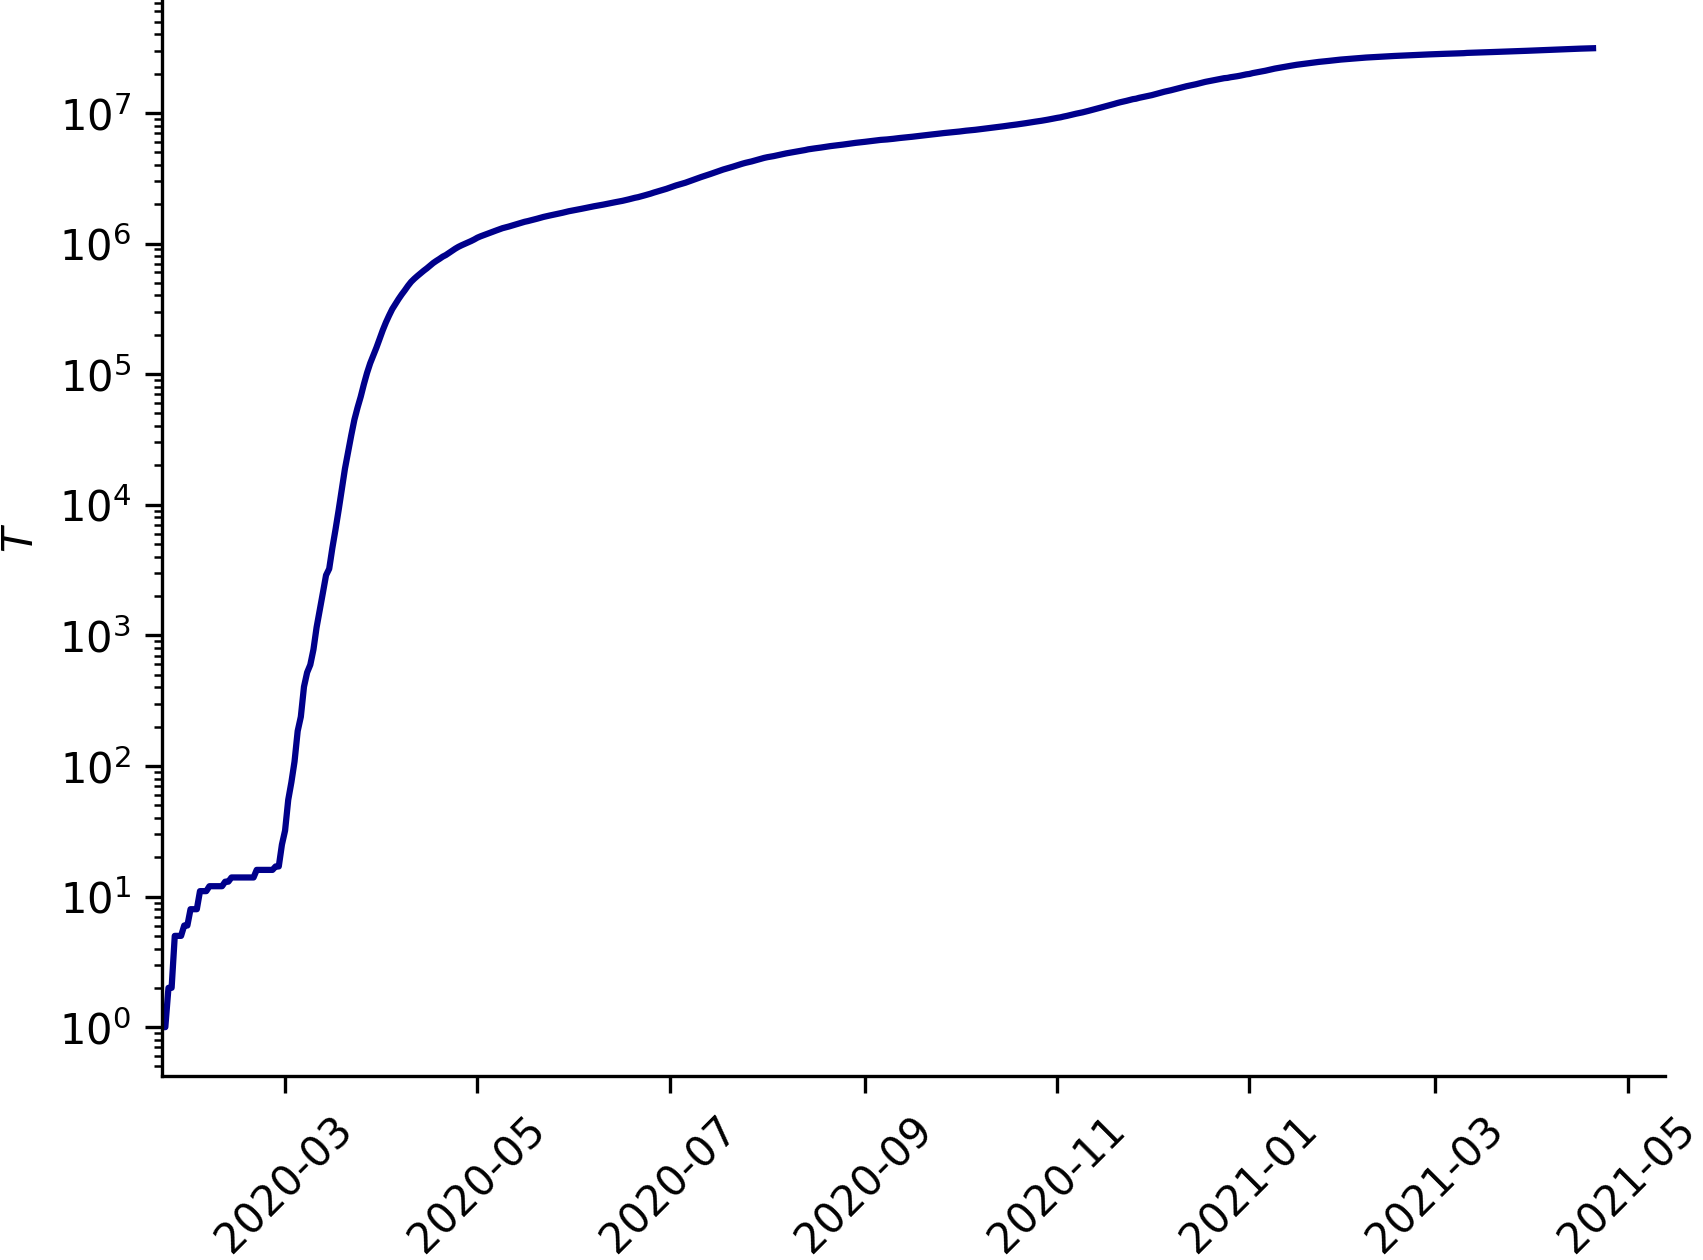

In [33]:
from IPython.display import Image
filepath = os.path.join(fig_dir , (fname + '.png'))
Image(filename=filepath, width=4./3*360)

### We merge the two datasets: The clusters dataset and the confirmed cases dataset

In [34]:
df_merge = df.merge(clusters_csse.T, on="index")
df_merge

leaves           X          Y  \
index                                  
0         746  -65.794825  18.277415   
1         458  -66.083320  18.131576   
2         873  -66.079340  18.396328   
3           8  -66.344566  18.363775   
4         641  -66.582628  18.044742   
...       ...         ...        ...   
1019      911 -158.026269  21.423245   
1020        7 -157.813184  21.329035   
1021      392 -156.517054  20.867763   
1022      808 -155.865732  19.692965   
1023      134 -155.089968  19.680449   

                                            cbg_clusters  population  \
index                                                                  
0      [720531504003, 720531501044, 720531505001, 720...    390728.0   
1      [720572702011, 720572703004, 720572705001, 720...    488287.0   
2      [720210307001, 720210310113, 720210316223, 720...   1011530.0   
3      [720399559001, 720399556001, 720399557001, 720...    425126.0   
4      [721130724005, 721130727011, 721130727012, 721...    354598.0   
...                                                  ...         ...   
1019   [150030078092, 150030078102, 150030099044, 150...    459209.0   
1020   [150090318011, 150099900000, 150030047001, 150...    529047.0   
1021   [150090311032, 150090304042, 150090309034, 150...    161290.0   
1022   [150010216012, 150010214023, 150010216041, 150...     88670.0   
1023   [150010210053, 150010210052, 150019904000, 150...    105010.0   

       2020-01-22 00:00:00  2020-01-23 00:00:00  2020-01-24 00:00:00  \
index                                                                  
0                        0                    0                    0   
1                        0                    0                    0   
2                        0                    0                    0   
3                        0                    0                    0   
4                        0                    0                    0   
...                    ...                  ...                  ...   
1019                     0                    0                    0   
1020                     0                    0                    0   
1021                     0                    0                    0   
1022                     0                    0                    0   
1023                     0                    0                    0   

       2020-01-25 00:00:00  2020-01-26 00:00:00  ...  2021-04-11 00:00:00  \
index                                            ...                        
0                        0                    0  ...                    0   
1                        0                    0  ...                    0   
2                        0                    0  ...                    0   
3                        0                    0  ...                    0   
4                        0                    0  ...                    0   
...                    ...                  ...  ...                  ...   
1019                     0                    0  ...                24243   
1020                     0                    0  ...                    0   
1021                     0                    0  ...                 3971   
1022                     0                    0  ...                 2629   
1023                     0                    0  ...                    0   

       2021-04-12 00:00:00  2021-04-13 00:00:00  2021-04-14 00:00:00  \
index                                                                  
0                        0                    0                    0   
1                        0                    0                    0   
2                        0                    0                    0   
3                        0                    0                    0   
4                        0                    0                    0   
...                    ...                  ...                  ...   
1019                 24291        

In [35]:
key_base = Path("/clustering")
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    key = str(key_base / "cluster_csse_merged")
    store[key] = df_merge

/tmp/ipykernel_65743/2231135975.py:4: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->axis0] [items->None]

  store[key] = df_merge
/tmp/ipykernel_65743/2231135975.py:4: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['cbg_clusters'], dtype='object')]

  store[key] = df_merge
/tmp/ipykernel_65743/2231135975.py:4: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->datetime,key->block3_items] [items->None]

  store[key] = df_merge


In [36]:
clusters_csse

index       0     1     2     3     4     5     6     7     8     9     ...  \
2020-01-22     0     0     0     0     0     0     0     0     0     0  ...   
2020-01-23     0     0     0     0     0     0     0     0     0     0  ...   
2020-01-24     0     0     0     0     0     0     0     0     0     0  ...   
2020-01-25     0     0     0     0     0     0     0     0     0     0  ...   
2020-01-26     0     0     0     0     0     0     0     0     0     0  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
2021-04-16     0     0     0     0     0     0     0     0  1544   412  ...   
2021-04-17     0     0     0     0     0     0     0     0  1556   416  ...   
2021-04-18     0     0     0     0     0     0     0     0  1560   420  ...   
2021-04-19     0     0     0     0     0     0     0     0  1561   423  ...   
2021-04-20     0     0     0     0     0     0     0     0  1567   424  ...   

index       1014  1015  1016  1017  1018   1019  1020  1021  1022  1023  
2020-01-22     0     0     0     0     0      0     0     0     0     0  
2020-01-23     0     0     0     0     0      0     0     0     0     0  
2020-01-24     0     0     0     0     0      0     0     0     0     0  
2020-01-25     0     0     0     0     0      0     0     0     0     0  
2020-01-26     0     0     0     0     0      0     0     0     0     0  
...          ...   ...   ...   ...   ...    ...   ...   ...   ...   ...  
2021-04-16     0     0   681     0   202  24537     0  4100  2671     0  
2021-04-17     0     0   681     0   203  24585     0  4136  2682     0  
2021-04-18     0     0   681     0   203  24678     0  4142  2692     0  
2021-04-19     0     0   683     0   203  24730     0  4152  2694     0  
2021-04-20     0     0   686     0   203  24754     0  4165  2695     0  

[455 rows x 1024 columns]